#What is going on in just one city?


So what is going on in Pittsburgh?

In [1]:
#general
import numpy as np
import scipy
from matplotlib import pyplot as plt
%pylab inline
import pandas as pd
import MySQLdb
import os
import sys
sys.setrecursionlimit(3000)

Populating the interactive namespace from numpy and matplotlib


In [3]:
con=MySQLdb.connect(user=user, passwd=passwd, db=dbname, host=host)
df2 = pd.read_sql("SELECT * FROM business WHERE state ='PA' ", con)
print "data loaded"

data loaded


In [3]:
print len(df2.categories.unique())

428


##Location Quotient

Location Quotient (LQ) is an indicator used in regional science and  planning to evaluate economic structure and specialty (Klosterman et. al., 1993). "The LQ is a measure which compares the relative importance (in terms of output or employment) of an business category in a region to its relative importance in the observed domain (Jensen, et. al., 1979)", so as to evaluate the deviation of region's business categories structure from that of the observed domain. A region showing greater than 1 of LQ for business category j is believed to be producing more than its share of  domain output in this business category j, and thus is defined as specialized in business category j.

$$LQ_{ij}=\frac{\frac{E_{ij}}{E_i}}{\frac{\sum_i E_{ij}}{\sum_i E_i}}$$
Where   
$E_{ij}$ is economic activity in subarea i, department j  
$E_i$ is total economic activity in subarea i   
$\sum_i E_{ij}$ is economic activity of department j in the whole area    
$\sum_i E_i$ is total economic activity in the whole area

In this analysis subarea is cluster, department is chosen business category, and the whole area is Phoenix. <br>
So let us start forming LQ.

In [4]:
EI_Ph = df2.review_count.sum()
lala = df2.groupby('categories').sum()
EI = lala.review_count
E_div = EI/EI_Ph

And, the denominator is done. 

To complete the rest of the variable, first the clusters need to be determined.

In [5]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
coordinates = df2.as_matrix(columns=['longitude', 'latitude'])

For Pittsburgh, I had to change max distance. If you look below to the distribution of the business in this city, you'll notice they have entirely different distribution than in Phoenix. Here business tend to follow more public transport, and apparently people in Pittsburgh walk more than people in Phoenix. Thus, walking distance between business have more sense here than in Phoenix. 

In [17]:
db = DBSCAN(eps=.003, min_samples=2).fit(coordinates)
labels = db.labels_
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
clusters = pd.Series([coordinates[labels == i] for i in xrange(num_clusters)])
print('Number of clusters: %d' % num_clusters)

Number of clusters: 271


In [18]:
def getCentroid(points):
    n = points.shape[0]
    sum_lon = np.sum(points[:, 1])
    sum_lat = np.sum(points[:, 0])
    return (sum_lon/n, sum_lat/n)

In [19]:
def getNearestPoint(set_of_points, point_of_reference):
    closest_point = None
    closest_dist = None
    for point in set_of_points:
        point = (point[1], point[0])
        dist = great_circle(point_of_reference, point).meters
        if (closest_dist is None) or (dist < closest_dist):
            closest_point = point
            closest_dist = dist
    return closest_point

In [20]:
lon = []
lat = []
for i, cluster in clusters.iteritems():
    if len(cluster) < 3:
        representative_point = (cluster[0][1], cluster[0][0])
    else:
        representative_point = getNearestPoint(cluster, getCentroid(cluster))
    lon.append(representative_point[0])
    lat.append(representative_point[1])
rs = pd.DataFrame({'lon':lon, 'lat':lat})

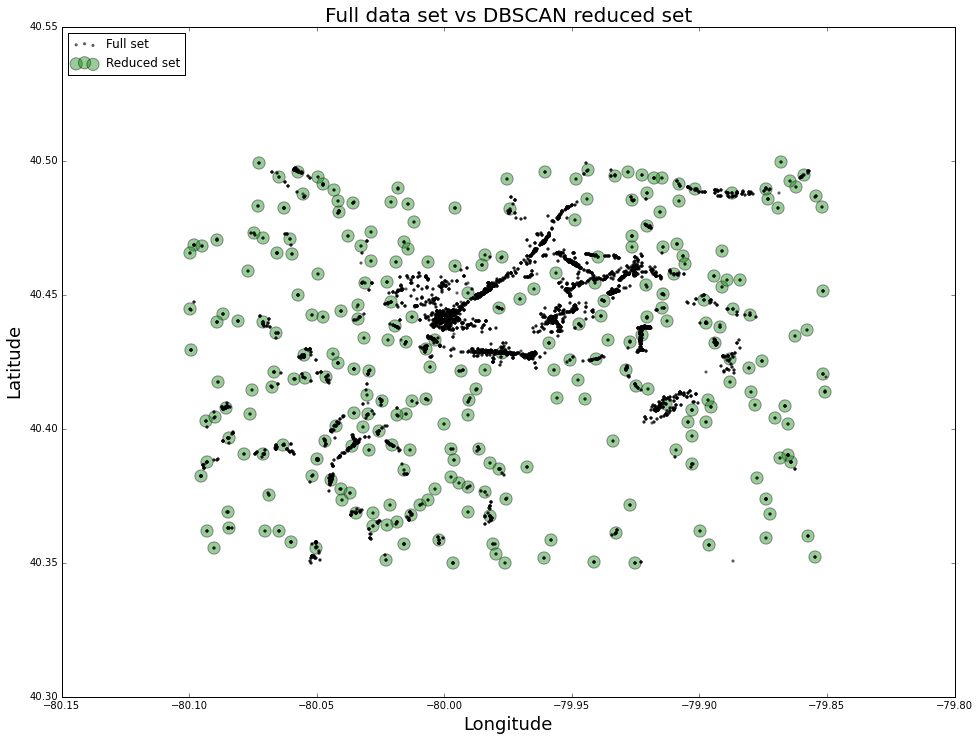

In [21]:
plt.figure(figsize=(16, 12), dpi=100)
rs_scatter = plt.scatter(rs['lat'], rs['lon'], c='g', alpha=.4, s=150)
df_scatter = plt.scatter(df2['longitude'], df2['latitude'], c='k', alpha=.5, s=5)
plt.title('Full data set vs DBSCAN reduced set', fontsize=20)
plt.legend((df_scatter, rs_scatter), ('Full set', 'Reduced set'), loc='upper left')
plt.xlabel('Longitude', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.show()

Add the column that denotes the cluster. 

In [22]:
df2['cluster']=0
i=0
for clus in clusters:
    for c in clus:
        df2.cluster.loc[(df2.longitude == c[0]) & (df2.latitude == c[1])]=i
    i=i+1

/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Add the column that denotes the denominator. 

In [23]:
df2['E_div']=0
i=0
for e in E_div:
    val=e
    cat=E_div.index[i]
    df2.E_div.loc[df2.categories==cat]=val
    i=i+1

/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
df2['EI']=0
for c in df2.cluster.unique():
        suma = df2.review_count[df2.cluster == c].sum()
        df2.EI.loc[df2.cluster ==c]=suma
#train.head(5)

/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
df2['LQ'] = (df2.review_count/df2.EI)/df2.E_div

/Users/Lexa/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [28]:
df2.head(5)

,Unnamed: 0,X,categories,city,full_address,latitude,longitude,name,open,review_count,stars,state,type,zipcode,cluster,E_div,EI,LQ
139465,139466,2,Nightlife,Dravosburg,"Dravosburg, PA 15034",40.350519,-79.88693,Clancy's Pub,True,4,3.5,PA,business,15034,0,0.047206,3006,0.028189
139466,139467,3,Active Life,Bethel Park,"Bethel Park, PA 15234",40.356896,-80.01591,Cool Springs Golf Center,False,5,2.5,PA,business,15234,224,0.006258,35,22.828972
139467,139468,4,Mini Golf,Bethel Park,"Bethel Park, PA 15234",40.356896,-80.01591,Cool Springs Golf Center,False,5,2.5,PA,business,15234,224,0.000055,35,2575.869048
139468,139469,5,Golf,Bethel Park,"Bethel Park, PA 15234",40.356896,-80.01591,Cool Springs Golf Center,False,5,2.5,PA,business,15234,224,0.000046,35,3091.042857
139469,139470,6,Shopping,Pittsburgh,"Pittsburgh, PA 15241",40.357620,-80.05998,Verizon Wireless,True,3,3.5,PA,business,15241,207,0.013149,18,12.675630
